# Indonesian Tweet Sentiment Analysis: ML vs DL Comparison

## Table of Contents
1. [Installation](#Installation)
2. [Setup and Imports](#Setup-and-Imports)
3. [Data Loading and Exploration](#Data-Loading-and-Exploration)
4. [Text Preprocessing](#Text-Preprocessing)
5. [Feature Engineering](#Feature-Engineering)
6. [Traditional ML Experiments](#Traditional-ML-Experiments)
7. [Deep Learning Experiments](#Deep-Learning-Experiments)
8. [Model Comparison](#Model-Comparison)
9. [Conclusions and Recommendations](#Conclusions-and-Recommendations)
10. [Exporting Results](#Exporting-Results)

# Installation

Install all dependencies

In [10]:
%pip install pexpect pandas numpy matplotlib seaborn nltk sastrawi scikit-learn tensorflow
!python -m nltk.downloader punkt

Note: you may need to restart the kernel to use updated packages.
/Users/nicoaudy/.local/share/uv/python/cpython-3.10.16-macos-x86_64-none/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /Users/nicoaudy/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Setup and Imports

Load all in one go

In [11]:
# Setup and imports cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Text preprocessing
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

All libraries imported successfully!
TensorFlow version: 2.16.2


# Data Loading and Exploration

=== DATA LOADING AND EXPLORATION ===
Dataset shape: (1815, 3)
Columns: ['Unnamed: 0', 'sentimen', 'tweet']

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1815 non-null   int64 
 1   sentimen    1815 non-null   object
 2   tweet       1815 non-null   object
dtypes: int64(1), object(2)
memory usage: 42.7+ KB
None

=== Missing Values ===
Unnamed: 0    0
sentimen      0
tweet         0
dtype: int64

=== Sentiment Distribution ===
sentimen
positif    612
netral     607
negatif    596
Name: count, dtype: int64
Percentage distribution:
sentimen
positif    33.72
netral     33.44
negatif    32.84
Name: count, dtype: float64


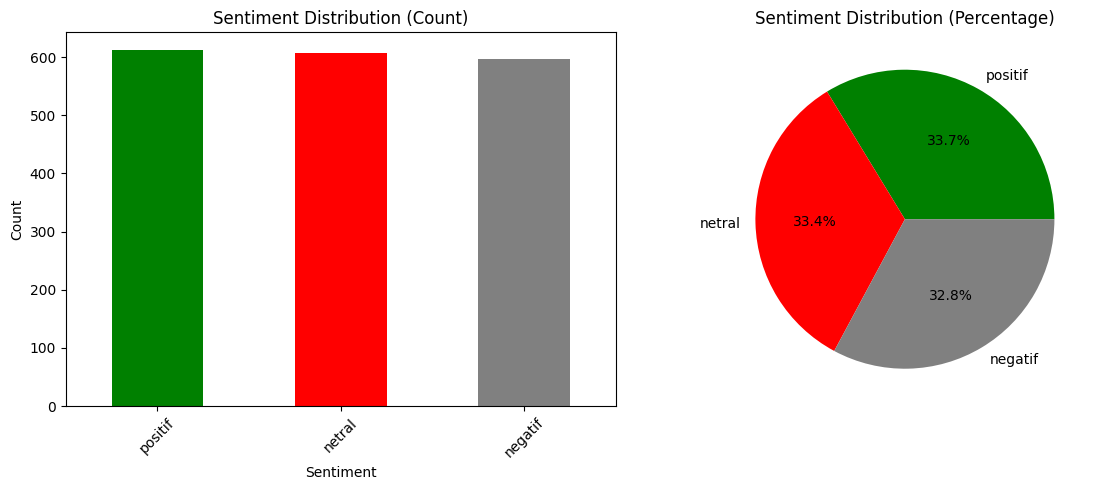


=== Sample Tweets ===

NEGATIF examples:
1. Kata @prabowo Indonesia tidak dihargai bangsa asing!   Berita ini ðŸ‘‡ pasti hoax buatan penguasa, y...
2. Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh...

NETRAL examples:
1. Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy?  http://dlvr.it/R2pvZVÂ ...
2. Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat ...

POSITIF examples:
1. Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. I...
2. Masa tenang msih ngoceh aja..ttp jokowi harga mati......


In [ ]:
# Data loading function
def load_and_explore_data(file_path=None):
    """Load CSV data and perform initial exploration"""
    print("=== DATA LOADING AND EXPLORATION ===")
    
    if file_path:
        # Load data from file
        df = pd.read_csv(file_path)
    else:
        # Create sample data
        sample_data = {
            'sentimen': ['negatif', 'netral', 'netral', 'positif', 'negatif', 'netral'] * 50,
            'tweet': [
                'Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini pasti hoax buatan penguasa',
                'Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy?',
                'Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi',
                'Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!',
                'Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh',
                'Yg bisikin pak jokowi, cm mikirin perputaran duit di golongan tertentu. E-Sports hanya sebagian kecil'
            ] * 50
        }
        df = pd.DataFrame(sample_data)
    
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Basic info
    print("\n=== Dataset Info ===")
    print(df.info())
    
    # Check for missing values
    print("\n=== Missing Values ===")
    print(df.isnull().sum())
    
    # Sentiment distribution
    print("\n=== Sentiment Distribution ===")
    sentiment_counts = df['sentimen'].value_counts()
    print(sentiment_counts)
    print(f"Percentage distribution:")
    print((sentiment_counts / len(df) * 100).round(2))
    
    # Plot sentiment distribution
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'])
    plt.title('Sentiment Distribution (Count)')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=['green', 'red', 'gray'])
    plt.title('Sentiment Distribution (Percentage)')
    
    plt.tight_layout()
    plt.show()
    
    # Sample tweets
    print("\n=== Sample Tweets ===")
    for sentiment in df['sentimen'].unique():
        print(f"\n{sentiment.upper()} examples:")
        samples = df[df['sentimen'] == sentiment]['tweet'].head(2)
        for i, tweet in enumerate(samples, 1):
            print(f"{i}. {tweet[:100]}...")
    
    return df

# Load data
filepath = input("Enter the path to the data file: ")
df = load_and_explore_data(filepath)  # Using sample data

# Text Preprocessing

=== TEXT PREPROCESSING ANALYSIS ===
Preprocessing texts...

=== Text Statistics ===
            Original  Processed
Avg Length    194.67     113.22
Avg Words      24.93      17.31


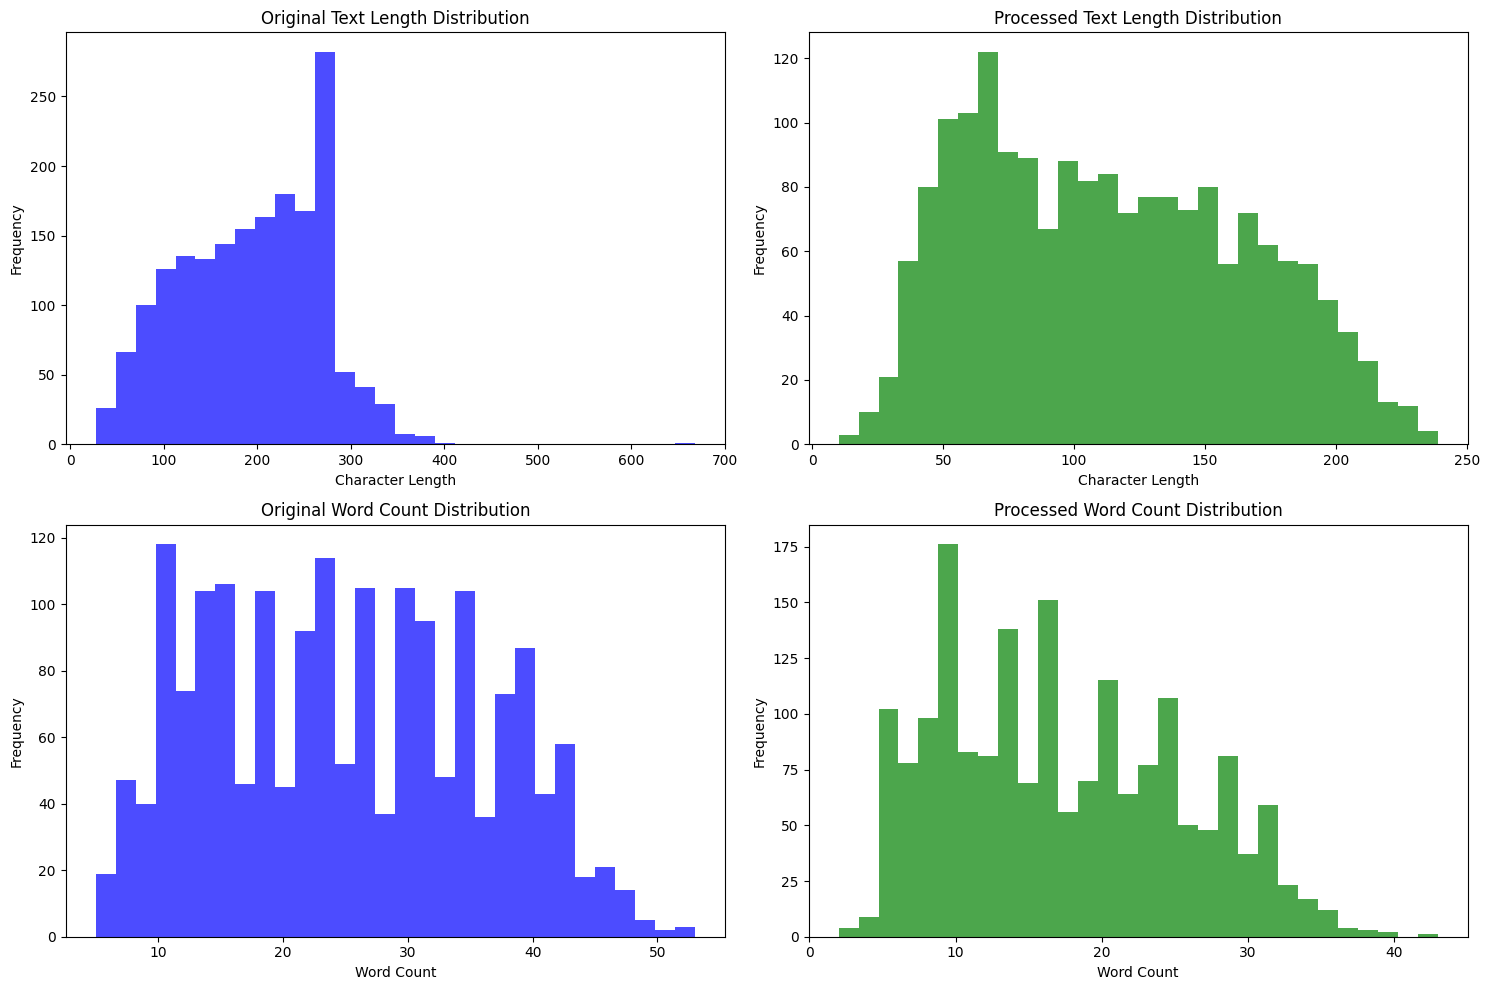


=== Preprocessing Examples ===

Example 1:
Original:  Kata @prabowo Indonesia tidak dihargai bangsa asing!   Berita ini ðŸ‘‡ pasti hoax buatan penguasa, y...
Processed: kata indonesia harga bangsa asing berita pasti hoax buat kuasa kan...

Example 2:
Original:  Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy?  http://dlvr.it/R2pvZVÂ ...
Processed: batu langka tasbih jokowi hadiah habib luthfi harga mercy...

Example 3:
Original:  Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat ...
Processed: era jokowi ekonomi indonesia makin baik pictwittercomwythnxstp...


In [14]:
# Text preprocessing class
class IndonesianTextPreprocessor:
    def __init__(self):
        # Download required NLTK data
        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt')
        
        # Initialize Indonesian-specific tools
        self.stemmer = StemmerFactory().create_stemmer()
        self.stopword_remover = StopWordRemoverFactory().create_stop_word_remover()
        
        # Additional Indonesian stopwords
        self.indonesian_stopwords = set([
            'yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 
            'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'itu',
            'dari', 'di', 'dengan', 'adalah', 'akan', 'atau', 'dalam', 'juga', 'sudah', 'dapat',
            'pak', 'bu', 'mas', 'mbak', 'bapak', 'ibu', 'saya', 'kami', 'kita', 'mereka'
        ])
    
    def clean_text(self, text):
        """Clean text: remove URLs, mentions, hashtags, special chars"""
        if pd.isna(text):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)
        
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text
    
    def preprocess_text(self, text):
        """Complete text preprocessing pipeline"""
        # Clean text
        text = self.clean_text(text)
        
        # Remove stopwords
        text = self.stopword_remover.remove(text)
        
        # Stem text
        text = self.stemmer.stem(text)
        
        # Remove custom stopwords
        words = text.split()
        words = [word for word in words if word not in self.indonesian_stopwords and len(word) > 2]
        
        return ' '.join(words)
    
    def analyze_text_stats(self, df, text_col='tweet'):
        """Analyze text statistics before and after preprocessing"""
        print("=== TEXT PREPROCESSING ANALYSIS ===")
        
        # Original text stats
        df['original_length'] = df[text_col].str.len()
        df['original_words'] = df[text_col].str.split().str.len()
        
        # Preprocess all texts
        print("Preprocessing texts...")
        df['cleaned_tweet'] = df[text_col].apply(self.preprocess_text)
        
        # Processed text stats
        df['processed_length'] = df['cleaned_tweet'].str.len()
        df['processed_words'] = df['cleaned_tweet'].str.split().str.len()
        
        # Statistics
        print("\n=== Text Statistics ===")
        stats_df = pd.DataFrame({
            'Original': [df['original_length'].mean(), df['original_words'].mean()],
            'Processed': [df['processed_length'].mean(), df['processed_words'].mean()]
        }, index=['Avg Length', 'Avg Words'])
        print(stats_df.round(2))
        
        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Length distribution
        axes[0,0].hist(df['original_length'], bins=30, alpha=0.7, label='Original', color='blue')
        axes[0,0].set_title('Original Text Length Distribution')
        axes[0,0].set_xlabel('Character Length')
        axes[0,0].set_ylabel('Frequency')
        
        axes[0,1].hist(df['processed_length'], bins=30, alpha=0.7, label='Processed', color='green')
        axes[0,1].set_title('Processed Text Length Distribution')
        axes[0,1].set_xlabel('Character Length')
        axes[0,1].set_ylabel('Frequency')
        
        # Word count distribution
        axes[1,0].hist(df['original_words'], bins=30, alpha=0.7, label='Original', color='blue')
        axes[1,0].set_title('Original Word Count Distribution')
        axes[1,0].set_xlabel('Word Count')
        axes[1,0].set_ylabel('Frequency')
        
        axes[1,1].hist(df['processed_words'], bins=30, alpha=0.7, label='Processed', color='green')
        axes[1,1].set_title('Processed Word Count Distribution')
        axes[1,1].set_xlabel('Word Count')
        axes[1,1].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
        
        # Show examples
        print("\n=== Preprocessing Examples ===")
        for i in range(3):
            print(f"\nExample {i+1}:")
            print(f"Original:  {df.iloc[i]['tweet'][:100]}...")
            print(f"Processed: {df.iloc[i]['cleaned_tweet'][:100]}...")
        
        return df

# Initialize preprocessor and process data
preprocessor = IndonesianTextPreprocessor()
df = preprocessor.analyze_text_stats(df)

# Feature Engineering

In [15]:
# Feature engineering function
def create_features(df):
    """Create various features for machine learning"""
    print("=== FEATURE ENGINEERING ===")
    
    # Text-based features
    df['char_count'] = df['cleaned_tweet'].str.len()
    df['word_count'] = df['cleaned_tweet'].str.split().str.len()
    df['avg_word_length'] = df['cleaned_tweet'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    df['exclamation_count'] = df['tweet'].str.count('!')
    df['question_count'] = df['tweet'].str.count('\?')
    df['mention_count'] = df['tweet'].str.count('@')
    df['hashtag_count'] = df['tweet'].str.count('#')
    df['uppercase_ratio'] = df['tweet'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
    
    # Most common words by sentiment
    print("\n=== Most Common Words by Sentiment ===")
    for sentiment in df['sentimen'].unique():
        text = ' '.join(df[df['sentimen'] == sentiment]['cleaned_tweet'])
        words = text.split()
        common_words = Counter(words).most_common(10)
        print(f"\n{sentiment.upper()}:")
        for word, count in common_words:
            print(f"  {word}: {count}")
    
    # Feature correlation with sentiment
    feature_cols = ['char_count', 'word_count', 'avg_word_length', 'exclamation_count',
                   'question_count', 'mention_count', 'hashtag_count', 'uppercase_ratio']
    
    print("\n=== Feature Statistics by Sentiment ===")
    feature_stats = df.groupby('sentimen')[feature_cols].mean()
    print(feature_stats.round(3))
    
    return df, feature_cols

df, feature_cols = create_features(df)

=== FEATURE ENGINEERING ===

=== Most Common Words by Sentiment ===

NEGATIF:
  ekonomi: 352
  jokowi: 186
  prabowo: 184
  gaji: 162
  harga: 128
  salah: 123
  gak: 111
  presiden: 99
  mau: 97
  rakyat: 96

NETRAL:
  ekonomi: 366
  jokowi: 233
  prabowo: 183
  gaji: 152
  harga: 134
  salah: 115
  indonesia: 104
  presiden: 100
  ambil: 91
  prabowosandi: 79

POSITIF:
  ekonomi: 287
  jokowi: 218
  gaji: 218
  prabowo: 202
  harga: 161
  presiden: 139
  sandi: 129
  indonesia: 117
  jadi: 116
  ambil: 104

=== Feature Statistics by Sentiment ===
          char_count  word_count  avg_word_length  exclamation_count  \
sentimen                                                               
negatif      124.430      19.478            5.476              0.248   
netral        92.530      13.720            5.892              0.051   
positif      122.812      18.757            5.674              0.160   

          question_count  mention_count  hashtag_count  uppercase_ratio  
sentimen  

# Traditional ML Experiments

Classes: ['negatif' 'netral' 'positif']
Encoded labels: [0 1 2]
=== CREATING TEXT FEATURES ===
TF-IDF shape: (1815, 4617)
Count features shape: (1815, 4617)
Additional features shape: (1815, 8)
=== TRADITIONAL ML EXPERIMENTS ===

Training Naive Bayes with TF-IDF Only...

Training Naive Bayes with Count Only...

Training Naive Bayes with TF-IDF + Features...

Training Naive Bayes with Count + Features...

Training SVM with TF-IDF Only...

Training SVM with Count Only...

Training SVM with TF-IDF + Features...

Training SVM with Count + Features...

Training Random Forest with TF-IDF Only...

Training Random Forest with Count Only...

Training Random Forest with TF-IDF + Features...

Training Random Forest with Count + Features...

Training Logistic Regression with TF-IDF Only...

Training Logistic Regression with Count Only...

Training Logistic Regression with TF-IDF + Features...

Training Logistic Regression with Count + Features...

=== TRADITIONAL ML RESULTS ===
                  M

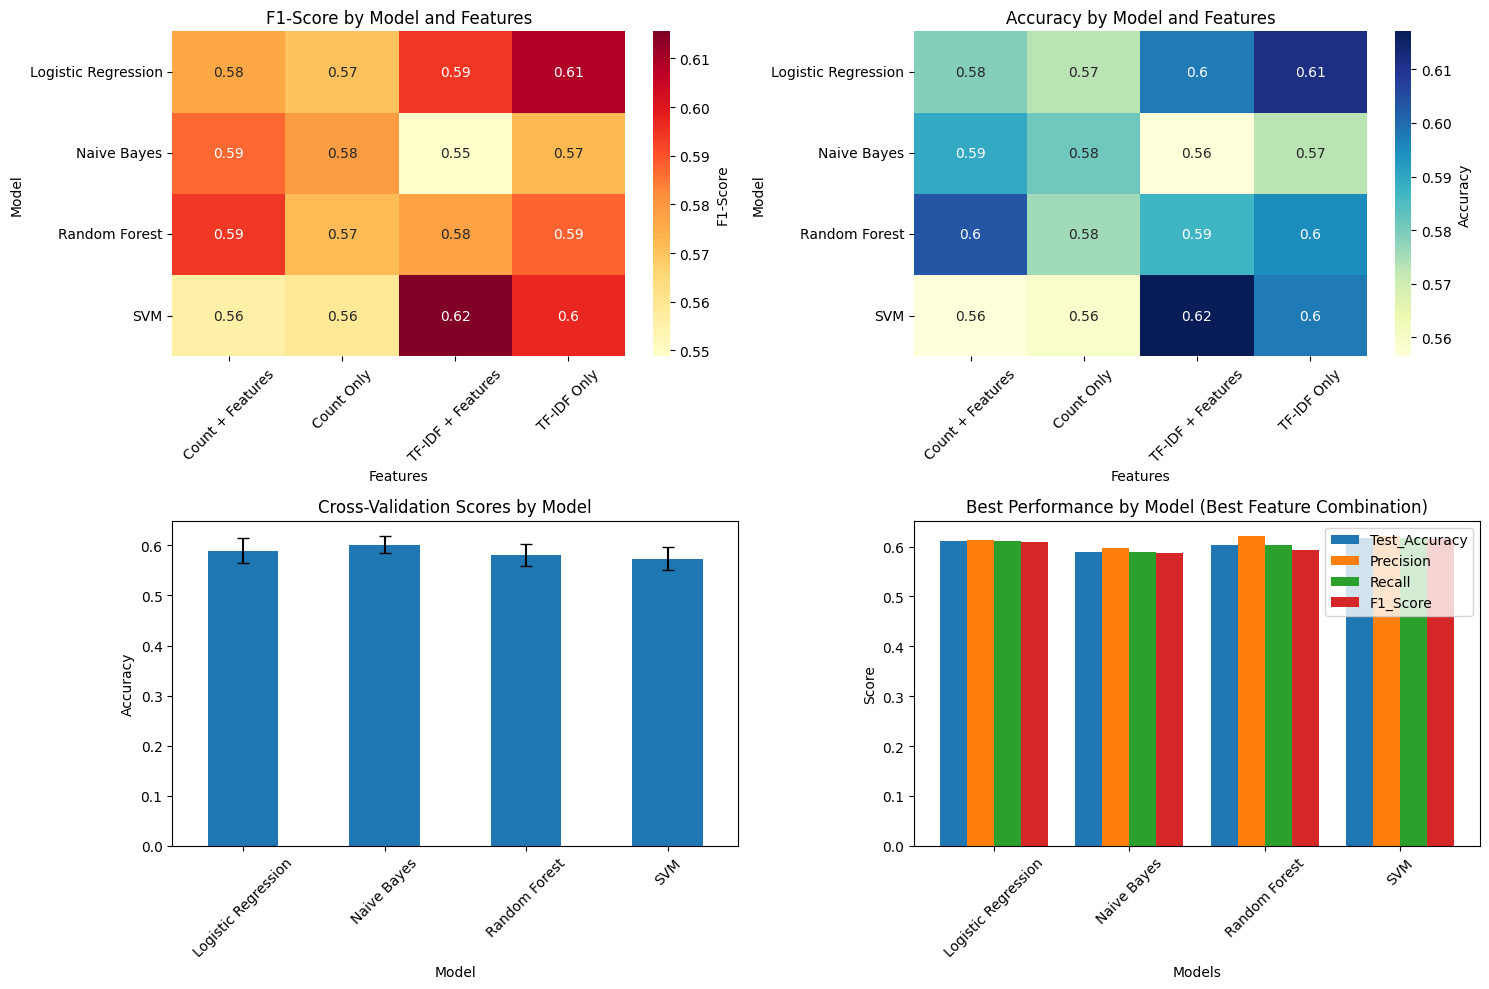

In [16]:
# ML experiments class
class MLExperiments:
    def __init__(self, df):
        self.df = df
        self.results = {}
        self.models = {}
        
        # Prepare data
        self.X_text = df['cleaned_tweet']
        self.X_features = df[feature_cols]
        self.y = df['sentimen']
        
        # Encode labels
        from sklearn.preprocessing import LabelEncoder
        self.label_encoder = LabelEncoder()
        self.y_encoded = self.label_encoder.fit_transform(self.y)
        
        print(f"Classes: {self.label_encoder.classes_}")
        print(f"Encoded labels: {np.unique(self.y_encoded)}")
    
    def create_text_features(self, max_features=5000):
        """Create TF-IDF and Count features"""
        print("=== CREATING TEXT FEATURES ===")
        
        # TF-IDF features
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.95
        )
        self.X_tfidf = self.tfidf_vectorizer.fit_transform(self.X_text)
        
        # Count features
        self.count_vectorizer = CountVectorizer(
            max_features=max_features,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.95
        )
        self.X_count = self.count_vectorizer.fit_transform(self.X_text)
        
        print(f"TF-IDF shape: {self.X_tfidf.shape}")
        print(f"Count features shape: {self.X_count.shape}")
        print(f"Additional features shape: {self.X_features.shape}")
    
    def train_traditional_models(self):
        """Train and evaluate traditional ML models"""
        print("=== TRADITIONAL ML EXPERIMENTS ===")
        
        # Models to test
        models = {
            'Naive Bayes': MultinomialNB(alpha=1.0),
            'SVM': SVC(kernel='linear', C=1.0, random_state=42),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
        }
        
        # Feature combinations to test
        feature_combinations = {
            'TF-IDF Only': self.X_tfidf,
            'Count Only': self.X_count,
            'TF-IDF + Features': np.hstack([self.X_tfidf.toarray(), self.X_features]),
            'Count + Features': np.hstack([self.X_count.toarray(), self.X_features])
        }
        
        # Cross-validation setup
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        results = []
        
        for model_name, model in models.items():
            for feature_name, X in feature_combinations.items():
                print(f"\nTraining {model_name} with {feature_name}...")
                
                # Cross-validation scores
                cv_scores = cross_val_score(model, X, self.y_encoded, cv=cv, scoring='accuracy')
                
                # Train on full data for detailed metrics
                X_train, X_test, y_train, y_test = train_test_split(
                    X, self.y_encoded, test_size=0.2, random_state=42, stratify=self.y_encoded
                )
                
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                
                # Calculate metrics
                accuracy = accuracy_score(y_test, y_pred)
                precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
                
                results.append({
                    'Model': model_name,
                    'Features': feature_name,
                    'CV_Mean': cv_scores.mean(),
                    'CV_Std': cv_scores.std(),
                    'Test_Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1_Score': f1
                })
                
                # Store best model for each combination
                key = f"{model_name}_{feature_name}"
                self.models[key] = model
        
        # Results DataFrame
        self.ml_results = pd.DataFrame(results)
        print("\n=== TRADITIONAL ML RESULTS ===")
        print(self.ml_results.round(4))
        
        # Find best model
        best_idx = self.ml_results['F1_Score'].idxmax()
        best_model = self.ml_results.iloc[best_idx]
        print(f"\nBest Traditional ML Model:")
        print(f"Model: {best_model['Model']} with {best_model['Features']}")
        print(f"F1-Score: {best_model['F1_Score']:.4f}")
        
        return self.ml_results
    
    def plot_ml_results(self):
        """Visualize ML results"""
        plt.figure(figsize=(15, 10))
        
        # F1-Score comparison
        plt.subplot(2, 2, 1)
        pivot_f1 = self.ml_results.pivot(index='Model', columns='Features', values='F1_Score')
        sns.heatmap(pivot_f1, annot=True, cmap='YlOrRd', cbar_kws={'label': 'F1-Score'})
        plt.title('F1-Score by Model and Features')
        plt.xticks(rotation=45)
        
        # Accuracy comparison
        plt.subplot(2, 2, 2)
        pivot_acc = self.ml_results.pivot(index='Model', columns='Features', values='Test_Accuracy')
        sns.heatmap(pivot_acc, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Accuracy'})
        plt.title('Accuracy by Model and Features')
        plt.xticks(rotation=45)
        
        # Cross-validation scores
        plt.subplot(2, 2, 3)
        models_cv = self.ml_results.groupby('Model')[['CV_Mean', 'CV_Std']].mean()
        models_cv['CV_Mean'].plot(kind='bar', yerr=models_cv['CV_Std'], capsize=4)
        plt.title('Cross-Validation Scores by Model')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        
        # Overall performance
        plt.subplot(2, 2, 4)
        metrics = ['Test_Accuracy', 'Precision', 'Recall', 'F1_Score']
        best_models = self.ml_results.loc[self.ml_results.groupby('Model')['F1_Score'].idxmax()]
        
        x = np.arange(len(best_models))
        width = 0.2
        
        for i, metric in enumerate(metrics):
            plt.bar(x + i*width, best_models[metric], width, label=metric)
        
        plt.xlabel('Models')
        plt.ylabel('Score')
        plt.title('Best Performance by Model (Best Feature Combination)')
        plt.xticks(x + width*1.5, best_models['Model'], rotation=45)
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Run traditional ML experiments
ml_exp = MLExperiments(df)
ml_exp.create_text_features()
ml_results = ml_exp.train_traditional_models()
ml_exp.plot_ml_results()

# Deep Learning Experiments

In [ ]:
# DL experiments class
class DeepLearningExperiments:
    def __init__(self, df):
        self.df = df
        self.X_text = df['cleaned_tweet']
        self.y = df['sentimen']
        
        # Encode labels for deep learning
        from sklearn.preprocessing import LabelEncoder
        self.label_encoder = LabelEncoder()
        self.y_encoded = self.label_encoder.fit_transform(self.y)
        self.y_categorical = to_categorical(self.y_encoded)
        self.num_classes = len(self.label_encoder.classes_)
        
        print(f"Number of classes: {self.num_classes}")
        print(f"Classes: {self.label_encoder.classes_}")
    
    def prepare_sequences(self, max_words=10000, max_length=100):
        """Prepare text sequences for deep learning"""
        print("=== PREPARING SEQUENCES FOR DEEP LEARNING ===")
        
        # Tokenize texts
        self.tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
        self.tokenizer.fit_on_texts(self.X_text)
        
        # Convert to sequences
        sequences = self.tokenizer.texts_to_sequences(self.X_text)
        
        # Pad sequences
        self.X_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
        
        # Vocabulary info
        self.vocab_size = min(max_words, len(self.tokenizer.word_index)) + 1
        self.max_length = max_length
        
        print(f"Vocabulary size: {self.vocab_size}")
        print(f"Sequence length: {self.max_length}")
        print(f"Sequences shape: {self.X_sequences.shape}")
        
        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X_sequences, self.y_categorical, test_size=0.2, random_state=42,
            stratify=self.y_encoded
        )
        
        print(f"Training data shape: {self.X_train.shape}")
        print(f"Test data shape: {self.X_test.shape}")
    
    def create_lstm_model(self, embedding_dim=100, lstm_units=64):
        """Create LSTM model"""
        model = Sequential([
            Embedding(self.vocab_size, embedding_dim, input_length=self.max_length),
            LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3),
            Dense(32, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def create_cnn_model(self, embedding_dim=100, filters=64, kernel_size=3):
        """Create CNN model"""
        model = Sequential([
            Embedding(self.vocab_size, embedding_dim, input_length=self.max_length),
            Conv1D(filters, kernel_size, activation='relu'),
            GlobalMaxPooling1D(),
            Dense(32, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def create_hybrid_model(self, embedding_dim=100, lstm_units=32, filters=32):
        """Create hybrid CNN-LSTM model"""
        model = Sequential([
            Embedding(self.vocab_size, embedding_dim, input_length=self.max_length),
            Conv1D(filters, 3, activation='relu'),
            LSTM(lstm_units, dropout=0.3),
            Dense(32, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train_deep_models(self, epochs=50, batch_size=32):
        """Train all deep learning models"""
        print("=== DEEP LEARNING EXPERIMENTS ===")
        
        # Early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # Models to train
        models_config = {
            'LSTM': self.create_lstm_model(),
            'CNN': self.create_cnn_model(),
            'CNN-LSTM': self.create_hybrid_model()
        }
        
        self.dl_results = []
        self.trained_models = {}
        
        for model_name, model in models_config.items():
            print(f"\nTraining {model_name} model...")
            print(model.summary())
            
            # Train model
            history = model.fit(
                self.X_train, self.y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=1
            )
            
            # Evaluate model
            test_loss, test_accuracy = model.evaluate(self.X_test, self.y_test, verbose=0)
            
            # Predictions for detailed metrics
            y_pred_prob = model.predict(self.X_test)
            y_pred = np.argmax(y_pred_prob, axis=1)
            y_true = np.argmax(self.y_test, axis=1)
            
            # Calculate metrics
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
            
            self.dl_results.append({
                'Model': model_name,
                'Test_Accuracy': test_accuracy,
                'Test_Loss': test_loss,
                'Precision': precision,
                'Recall': recall,
                'F1_Score': f1,
                'Epochs_Trained': len(history.history['loss'])
            })
            
            self.trained_models[model_name] = {
                'model': model,
                'history': history,
                'predictions': y_pred,
                'true_labels': y_true
            }
        
        # Results DataFrame
        self.dl_results_df = pd.DataFrame(self.dl_results)
        print("\n=== DEEP LEARNING RESULTS ===")
        print(self.dl_results_df.round(4))
        
        # Find best model
        best_idx = self.dl_results_df['F1_Score'].idxmax()
        best_model = self.dl_results_df.iloc[best_idx]
        print(f"\nBest Deep Learning Model:")
        print(f"Model: {best_model['Model']}")
        print(f"F1-Score: {best_model['F1_Score']:.4f}")
        
        return self.dl_results_df
    
    def plot_dl_results(self):
        """Visualize deep learning results"""
        plt.figure(figsize=(15, 12))
        
        # Training histories
        plt.subplot(2, 3, 1)
        for model_name, model_info in self.trained_models.items():
            history = model_info['history']
            plt.plot(history.history['accuracy'], label=f'{model_name} Train')
            plt.plot(history.history['val_accuracy'], label=f'{model_name} Val', linestyle='--')
        plt.title('Training & Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.subplot(2, 3, 2)
        for model_name, model_info in self.trained_models.items():
            history = model_info['history']
            plt.plot(history.history['loss'], label=f'{model_name} Train')
            plt.plot(history.history['val_loss'], label=f'{model_name} Val', linestyle='--')
        plt.title('Training & Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Model comparison
        plt.subplot(2, 3, 3)
        metrics = ['Test_Accuracy', 'Precision', 'Recall', 'F1_Score']
        x = np.arange(len(self.dl_results_df))
        width = 0.2
        
        for i, metric in enumerate(metrics):
            plt.bar(x + i*width, self.dl_results_df[metric], width, label=metric)
        
        plt.xlabel('Models')
        plt.ylabel('Score')
        plt.title('Deep Learning Models Performance')
        plt.xticks(x + width*1.5, self.dl_results_df['Model'])
        plt.legend()
        
        # Confusion matrices
        for i, (model_name, model_info) in enumerate(self.trained_models.items()):
            plt.subplot(2, 3, 4 + i)
            cm = confusion_matrix(model_info['true_labels'], model_info['predictions'])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.label_encoder.classes_,
                       yticklabels=self.label_encoder.classes_)
            plt.title(f'{model_name} Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
        
        plt.tight_layout()
        plt.show()

# Run deep learning experiments
dl_exp = DeepLearningExperiments(df)
dl_exp.prepare_sequences()
dl_results = dl_exp.train_deep_models(epochs=20)  # Reduced epochs for demo
dl_exp.plot_dl_results()

Number of classes: 3
Classes: ['negatif' 'netral' 'positif']
=== PREPARING SEQUENCES FOR DEEP LEARNING ===
Vocabulary size: 5405
Sequence length: 100
Sequences shape: (1815, 100)
Training data shape: (1452, 100)
Test data shape: (363, 100)
=== DEEP LEARNING EXPERIMENTS ===

Training LSTM model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.3244 - loss: 1.1012 - val_accuracy: 0.3024 - val_loss: 1.1043
Epoch 2/20
